# ICP


## Task 1 Point-to-point ICP 

In [1]:
import time

import numpy as np
from math import sin, cos

import sys,os

# Loading libraries for visualisation
import matplotlib.pyplot as plt

# Loading libraries for basic geometry processing
import trimesh
import numpy as np
from sklearn.neighbors import KDTree

In [2]:
#Load mesh data
bunny000_path = "bun000_v2.ply"
bunny045_path = "bun045_v2.ply"

assert os.path.exists(bunny000_path), 'can not find document: ' + bunny000_path
assert os.path.exists(bunny045_path), 'can not find document: ' + bunny045_path

bun000 = trimesh.load(bunny000_path)
bun045 = trimesh.load(bunny045_path)

#Extract point clouds
bun000_pts = bun000.vertices
bun045_pts = bun045.vertices

#Now we have 2 sets of point clouds

#Check
print(bun000_pts.shape)
print(bun045_pts.shape)

(40245, 3)
(40091, 3)


d:\ProgramData\Anaconda3\envs\geo_tutorials\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


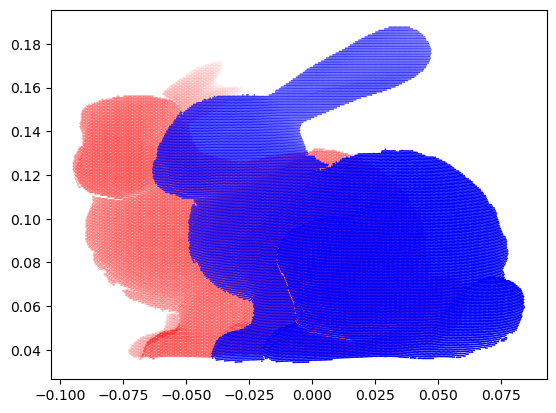

In [3]:
#Visualise the data
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')

plt.scatter(bun000_pts[:,0], bun000_pts[:,1], bun000_pts[:,2], c='r', marker='o')
plt.scatter(bun045_pts[:,0], bun045_pts[:,1], bun045_pts[:,2], c='b', marker='^')

#ax.set_title('Aligned Point Clouds')
plt.show()

# Point-to-point ICP

In [4]:
#Find nearest neighbors

#Determine threshold
tree = KDTree(bun045_pts)
distances, ids = tree.query(bun000_pts, return_distance=True)
#Determine threshold
q75, q25 = np.percentile(distances, [75 ,25])
iqr = q75 - q25
threshold = q75 + 1.5 * iqr
#threshold = 1000
print(threshold)

def find_nearest_pts(source_pts, target_pts, threshold):
    #Create KDTree
    kdtree = KDTree(source_pts)    
    #Find the closest point in the source point set for each target point
    distances, indices = kdtree.query(target_pts, return_distance=True)
    #print(indices)
    
    # Get the closest point from the source point set using index
    nearest_pts = np.squeeze(source_pts[indices])    

     # Filter out points whose distance is greater than a threshold
    valid_indices = distances.flatten() < threshold
    #valid_indices = indices[valid_indices]
    # print(len(valid_indices))
    # print(valid_indices)
    nearest_pts = nearest_pts[valid_indices]
    #print(nearest_pts.shape)
    dest_pts = target_pts[valid_indices]    
    #source_pts_new = source_pts[valid_indices]         
    
    return nearest_pts, dest_pts

   

0.059536940861198054


In [5]:
#Define error function
def compute_error(source_pts, target_pts):
    #Insure points are numpy array format
    source_pts = np.array(source_pts)
    target_pts = np.array(target_pts)

    diff = target_pts - source_pts
    error = np.sum(diff**2)
    
    return error

In [6]:
#Fit transform matrix note that target points are fixed
def fit_transform(source_pts, target_pts):
    
    assert len(source_pts) == len(target_pts)

    centroid_source = np.mean(source_pts, 0)
    centroid_target = np.mean(target_pts, 0)

    #Centralise point clouds (Remove the influence of transition)
    centered_source = source_pts - centroid_source
    centered_target = target_pts - centroid_target

    A = centered_source.T @ centered_target
    U, S, Vt = np.linalg.svd(A)

    #Rotation matrix
    R = Vt.T @ U.T
    #If flip
    if np.linalg.det(R) < 0:
       Vt[-1,:] *= -1
       R = Vt.T @ U.T
    
    #Transition 
    t = centroid_target - R @ centroid_source

    #Transform matrix, combine R and T
    T = np.identity(len(R)+1)
    T[:len(R), :len(R)] = R
    T[:len(R), len(R)] = t

    return T


In [7]:
#ICP main
def icp(source_pts, target_pts, max_iterations=50, tolerance=0.001):
    source_pts = np.array(source_pts)
    target_pts = np.array(target_pts)

    errors = []
    #Initialise error to infinity
    prev_error = float('inf')
    for i in range(max_iterations):
        #Find nearest points        
        nearest_pts, dest_pts = find_nearest_pts(source_pts, target_pts, threshold)
        nearest_pts = np.array(nearest_pts)        
        #Fit transformation matrix
        T = fit_transform(nearest_pts, dest_pts)
        #Apply transformation
        source_pts = (np.dot(T[:3,:3], source_pts.T).T + T[:3,3]).astype(np.float32)
        #Compute current error       
        current_error = compute_error(nearest_pts, dest_pts)
        errors.append(current_error)
        if np.abs(prev_error - current_error) < tolerance:
            break
        prev_error = current_error
    print(f'Total iterations: {i+1}')
    print(f'Final error: {current_error}')

    return T, source_pts, errors
    

In [8]:
#Apply ICP
start_time = time.time()
T, transformed_pts, errors = icp(bun045_pts, bun000_pts)
end_time = time.time()
runtime = end_time - start_time
print(f"ICP point-to-point runtime: {runtime} seconds")

Total iterations: 22
Final error: 0.39110837686877836
ICP point-to-point runtime: 3.6748170852661133 seconds


In [9]:
def numpy_to_obj(vertices, filename='output.obj'):
    
    with open(filename, 'w') as obj_file:
        for vertex in vertices:
            obj_file.write('v {} {} {}\n'.format(*vertex))
    print(f'OBJ file saved to {filename}')

d:\ProgramData\Anaconda3\envs\geo_tutorials\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


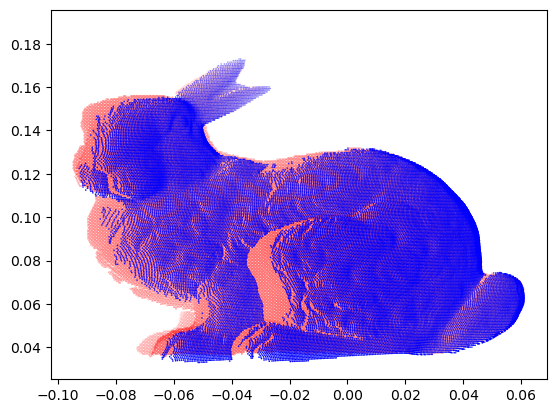

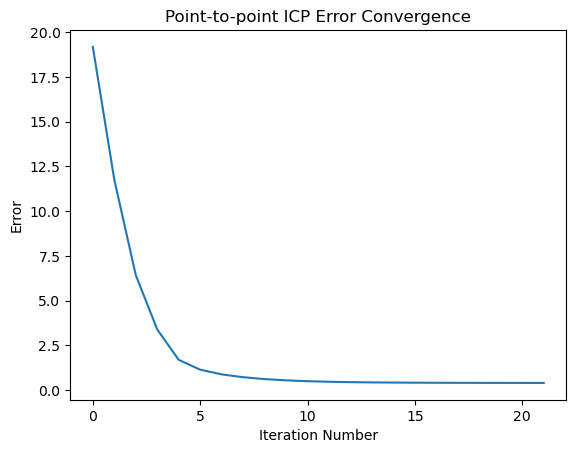

OBJ file saved to task1_45.obj
OBJ file saved to task1_00.obj


In [10]:
#Visualization
fig = plt.figure()
plt.scatter(bun000_pts[:,0], bun000_pts[:,1], bun000_pts[:,2], c='r', marker='o')
plt.scatter(transformed_pts[:,0], transformed_pts[:,1], transformed_pts[:,2], c='b', marker='^')
plt.show()

plt.plot(errors)
plt.title('Point-to-point ICP Error Convergence')
plt.xlabel('Iteration Number')
plt.ylabel('Error')
plt.show()


numpy_to_obj(transformed_pts, 'task1_45.obj')
numpy_to_obj(bun000_pts, 'task1_00.obj')


# Point-to-plane ICP

In [11]:
#Least square based normal estimation
def lstsq_plane_fitting(surface_points, k):
    ### fill in this function. normals should have same dimension as surface_points (nx3)
    ### k is the number of neighbours

    num_points, _ = surface_points.shape
    tree = KDTree(surface_points)
    _, indices = tree.query(surface_points, k)
    normals = np.zeros([num_points,3])
    for point in range(num_points):
        neighbours = surface_points[indices[point],:]
        (a, b, c), residual, rank, s = np.linalg.lstsq(neighbours, np.ones([k]))
        normal = (a, b, c)
        nn = np.linalg.norm(normal)
        normal = normal / nn
        normals[point,:]= normal

    
    return normals

In [12]:
#Compute point-to-plane error
def compute_error_p2plane(source_pts, target_pts): #compute errors between correspondences
    #compute normals of target points
    normals = lstsq_plane_fitting(target_pts, 3)
    
    source_pts = np.array(source_pts)
    target_pts = np.array(target_pts)
    
    diff = np.einsum('ij,ij->i', target_pts - source_pts, normals) #Check later
    error = np.sum(diff**2)
    #print(diff.shape)

    return error

In [13]:
def build_rotation_matrix(alpha, beta, gamma):     
    #Construct a rotation matrix based on the rotation angles(radian) around z axes
    
    r11 = cos(gamma) * cos(beta)
    r12 = -sin(gamma) * cos(alpha) + cos(gamma) * sin(beta) * sin(alpha)
    r13 = sin(gamma) * sin(alpha) + cos(gamma) * sin(beta) * cos(alpha)
    
    r21 = sin(gamma) * cos(beta)
    r22 = cos(gamma) * cos(alpha) + sin(gamma) * sin(beta) * sin(alpha)
    r23 = -cos(gamma) * sin(alpha) + sin(gamma) * sin(beta) * cos(alpha)

    r31 = -sin(beta)
    r32 = cos(beta) * sin(alpha)
    r33 = cos(beta) * cos(alpha)

    R_matrix = np.array([[r11, r12, r13, 0],
                         [r21, r22, r23, 0],
                         [r31, r32, r33, 0],
                         [0  , 0  , 0  , 1]])
    
    return R_matrix

In [14]:
def build_A_matrix(source_pts, target_normals):
    num_pts, dimension = source_pts.shape

    A = np.zeros((num_pts, dimension * 2))
    A[:, 0] = target_normals[:, 2] * source_pts[:, 1] - target_normals[:, 1] * source_pts[:, 2]
    A[:, 1] = target_normals[:, 0] * source_pts[:, 2] - target_normals[:, 2] * source_pts[:, 0]
    A[:, 2] = target_normals[:, 1] * source_pts[:, 0] - target_normals[:, 0] * source_pts[:, 1]
    A[:, 3:] = target_normals
    #print(A.shape)

    return A


In [15]:
def build_b_vector(source_pts, target_pts, target_normals):
    num_pts, _ = source_pts.shape

    b = np.zeros((num_pts, 1))
    
    nx = target_normals[:, 0]
    ny = target_normals[:, 1]
    nz = target_normals[:, 2]
    sx = source_pts[:, 0]
    sy = source_pts[:, 1]
    sz = source_pts[:, 2]
    dx = target_pts[:, 0]
    dy = target_pts[:, 1]
    dz = target_pts[:, 2]

    b = nx * dx + ny * dy + nz * dz - nx * sx - ny * sy - nz * sz

    return b

In [16]:
def solve_linear_equation(A, b):
    U, S, Vt = np.linalg.svd(A)
    # print(U.shape)
    # print(S.shape)
    # print(Vt.shape)
    S_diag = np.diag(1.0/S)
    S_matrix = np.zeros((len(S), A.shape[0]))
    S_matrix[:len(S), :len(S)] = S_diag
    
    A_pinv = Vt.T @ S_matrix @ U.T

    x = A_pinv @ b

    return x

In [17]:
def fit_transform_p2plane(source_pts, target_pts):
    num_pts, dimension = source_pts.shape
    target_normals = lstsq_plane_fitting(target_pts, 3)

    A = build_A_matrix(source_pts, target_normals)
    #print(A.shape)
    b = build_b_vector(source_pts, target_pts, target_normals)
    x = solve_linear_equation(A, b)

    alpha = x[0]
    beta = x[1]
    gamma = x[2]

    R = build_rotation_matrix(alpha, beta, gamma)

    transition = np.identity(dimension + 1)
    transition[:dimension, -1] = x[dimension:]

    T = transition @ R
    #print(T)

    return T

In [18]:
def icp_p2plane(source_pts, target_pts, max_iterations=50, tolerance=0.001):
    source_pts = np.array(source_pts)
    target_pts = np.array(target_pts)

    errors = []
    #Initialise error to infinity
    prev_error = float('inf')
    
    for i in range(max_iterations):
        #Find correspondences        
        nearest_pts, dest_pts = find_nearest_pts(source_pts, target_pts, threshold)
        nearest_pts = np.array(nearest_pts)
        # print(dest_pts.shape)
        # print(nearest_pts.shape)
        #Fit transformation matrix
        T = fit_transform_p2plane(nearest_pts, dest_pts)
        #Apply transformation
        source_pts = (np.dot(T[:3,:3], source_pts.T).T + T[:3,3]).astype(np.float32)   
                
        #Compute current error        
        current_error = compute_error_p2plane(nearest_pts, dest_pts)
        errors.append(current_error)
        if np.abs(prev_error - current_error) < tolerance:
            break
        prev_error = current_error
    print(f'Total iterations: {i+1}')
    print(f'Final error: {current_error}')

    return T, source_pts, errors

In [21]:
#Sample data
bun045_sample = bun045.sample(25000)
bun000_sample = bun000.sample(25000)
start_time = time.time()
T_p2plane, transformed_p2plane, errors_p2plane = icp_p2plane(bun045_sample, bun000_sample)
end_time = time.time()
runtime = end_time - start_time
print(f"ICP point-to-plane runtime: {runtime} seconds")

C:\Users\23657\AppData\Local\Temp\ipykernel_23752\1562814891.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b, c), residual, rank, s = np.linalg.lstsq(neighbours, np.ones([k]))
C:\Users\23657\AppData\Local\Temp\ipykernel_23752\1562814891.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b, c), residual, rank, s = np.linalg.lstsq(neighbours, np.ones([k]))
C:\Users\23657\AppData\Local\Temp\ipykernel_23752\1562814891.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision t

Total iterations: 8
Final error: 0.11999170626509323
ICP point-to-plane runtime: 79.58492159843445 seconds


d:\ProgramData\Anaconda3\envs\geo_tutorials\lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


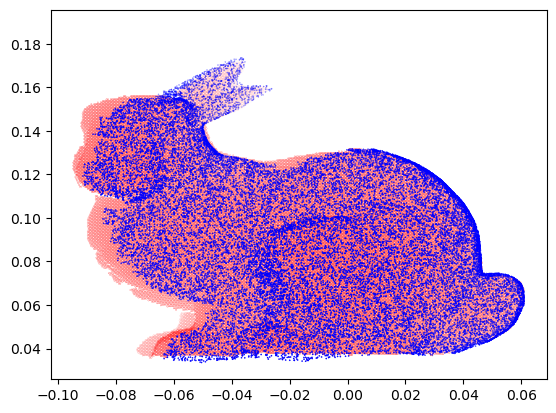

In [ ]:
#Visualization
fig = plt.figure()
plt.scatter(bun000_pts[:,0], bun000_pts[:,1], bun000_pts[:,2], c='r', marker='o')
plt.scatter(transformed_p2plane[:,0], transformed_p2plane[:,1], transformed_p2plane[:,2], c='b', marker='^')
plt.show()

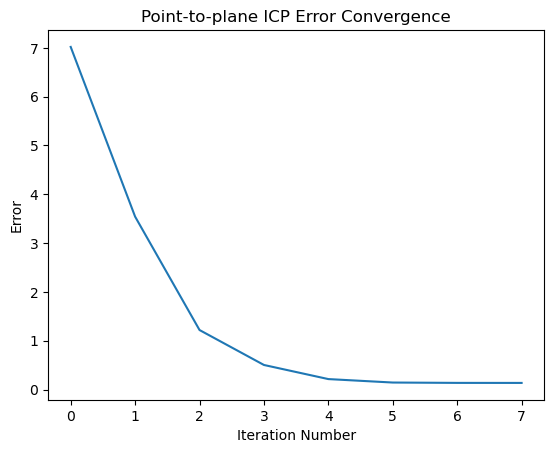

OBJ file saved to task5_45.obj


In [ ]:
plt.plot(errors_p2plane)
plt.title('Point-to-plane ICP Error Convergence')
plt.xlabel('Iteration Number')
plt.ylabel('Error')
plt.show()


numpy_to_obj(transformed_p2plane, 'task5_45.obj')
#numpy_to_obj(bun000_pts, 'task1_00.obj')